In [1]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [2]:
# edit this with you data path
url = "../input/ccdata/CC GENERAL.csv"
dataset = pd.read_csv(url)

# 1 Introduction
Generally speaking, all metrics are numerial (except the first one that serves as ID and will be deleted immediately). We notice a huge discrepancy in terms of scales, some variable are presented to us as percentages while others varies on a much more larger scale, an issue that we will deal with later.
Before diving into details, We can draw some hypothesises on colinearity cases between variables (variable that are linked to each other in one way or other). These are just hypothetical statements based on the meaning of each metrics. 

# 2 Quick Analysis of the basic metrics.
The metrics PURCHASES, ONEOFFPURCHASES,INSTALLMENTSPURCHASES are most likely linked to each other, a large purchased amount would likely mean a larger ONEOFFPURCHASES or INSTALLMENTSPURCHASES, in fact the relationship is simple : PURCHASES = ONEOFFPURCHASES + INSTALLMENTSPURCHASES. We can just replace the column ONEOFFPURCHASES by ONEOFFPURCHASES/PURCHASES  and  INSTALLMENTSPURCHASES by INSTALLMENTSPURCHASES/PURCHASES and delete the column PURCHASES. These operations will not only eliminate colinearity but also scale the columns INSTALLMENTSPURCHASES and
ONEOFFPURCHASES as we will have to deal with percentages that better reflect the user manner (whether he conducts buys immediately or proceeds by installments depending on the percentage) instead of arbitrary values that wouldn't mean a lot since it's are corrolated the total purchases.\\The same hypothesis could be made on
PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY, the metric PURCHASES_FREQUENCY could be left intact as it's  probably not corrolated to the amount of purchases (frequency means how often the user is active with his credit card and doesn't necessarily link to the amount of purchases, a user could conduct huge amounts of buys rarely). However ONEOFF_PURCHASES_FREQUENCY, and PURCHASES_INSTALLMENTS_FREQUENCY directly link to PURCHASES, therefore we could omit them.
CASHADVANCE based on its description, we can already say that its range values will vary arbitrarily and won't be scaled within 0 and 1 as most of the other metrics.It's most likely linked to CASHADVANCETRX, in fact the cash given in advance is proportional to the number of transactions made with cash in advance. Therefore it would be good to replace CASHADVANCE by CASHADVANCE/CASHADVANCETRX and replace CASHADVANCETRX by CASHADVANCETRX/PURCHASESTRX.


In [3]:
#Shape : Dimensions de l'ensemble de données
print(dataset.shape)
# Head
print(dataset.head(dataset.size))



(8950, 18)
     CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     C10001    40.900749           0.818182      95.40              0.00   
1     C10002  3202.467416           0.909091       0.00              0.00   
2     C10003  2495.148862           1.000000     773.17            773.17   
3     C10004  1666.670542           0.636364    1499.00           1499.00   
4     C10005   817.714335           1.000000      16.00             16.00   
...      ...          ...                ...        ...               ...   
8945  C19186    28.493517           1.000000     291.12              0.00   
8946  C19187    19.183215           1.000000     300.00              0.00   
8947  C19188    23.398673           0.833333     144.40              0.00   
8948  C19189    13.457564           0.833333       0.00              0.00   
8949  C19190   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY 

# 3 Missing values
Let's now deal with missing values, and eliminate the first column.

In [4]:
dataset = dataset.dropna()
del dataset["CUST_ID"]
print(dataset.shape)
print(dataset.head(dataset.size))

(8636, 17)
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
2     2495.148862           1.000000     773.17            773.17   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
...           ...                ...        ...               ...   
8943     5.871712           0.500000      20.90             20.90   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.

# 3 Univariate analysis


## 3.1 Balance
Most credit card users owe less than 2000. As shown by the statistics, only 25% out of the total owe more than 2105.19. a very small group of the users owes outrageous amount (greater than 7500) while very few owes something close to 19043, to the point where they could be considered noisy. 

count     8636.000000
mean      1601.224893
std       2095.571300
min          0.000000
25%        148.095189
50%        916.855459
75%       2105.195853
max      19043.138560
Name: BALANCE, dtype: float64
variation coefficient : 1.3087301538264156


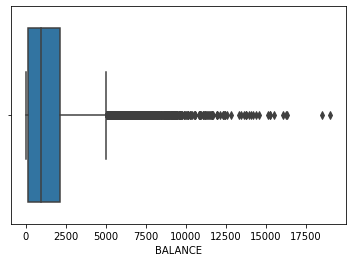

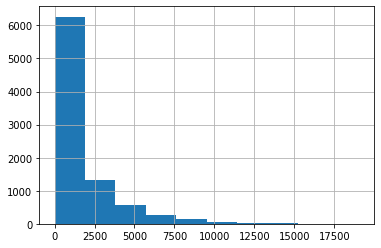

In [5]:
print(dataset["BALANCE"].describe())
print("variation coefficient :",dataset["BALANCE"].describe()["std"]/dataset["BALANCE"].describe()["mean"] )
ax = sns.boxplot(x=dataset["BALANCE"])
plt.show()
dataset["BALANCE"].hist()
plt.show()

In [6]:
index_names = dataset[ dataset['BALANCE'] > 12500].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
2     2495.148862           1.000000     773.17            773.17   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
...           ...                ...        ...               ...   
8943     5.871712           0.500000      20.90             20.90   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.2 Balance frequency
Let's now analyse how frequent the user pay to balance their account credit (or simply pay the money they owe). In contrast to earlier, the metric BALANCE_FREQUENCY shows a clear dominance of that group of user that constantly pay their debt on a daily basis (a frequency balance close to 1 for a large proportion of user, 6500/8636 almost). The 1st quatile says it all, 75% of the population have a frequency balance higher that 90% which reassures the credit issuers) This analysis explains the distribution of the metrics BAlANCE. In fact those who have a pretty high BALANCE rarely pay their debt, this small cluster of people are the same people who have a pretty low BALANCE_FREQUENCY (almost never pay their debt). These two metrcis are inversely colinear.

count    8614.000000
mean        0.894767
std         0.207894
min         0.000000
25%         0.909091
50%         1.000000
75%         1.000000
max         1.000000
Name: BALANCE_FREQUENCY, dtype: float64
variation coefficient : 0.23234441061932545


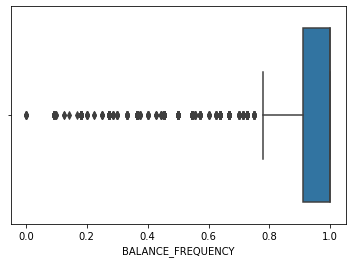

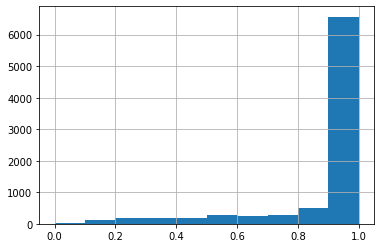

In [7]:
print(dataset["BALANCE_FREQUENCY"].describe())
print("variation coefficient :",dataset["BALANCE_FREQUENCY"].describe()["std"]/dataset["BALANCE_FREQUENCY"].describe()["mean"])
ax = sns.boxplot(x=dataset["BALANCE_FREQUENCY"])
plt.show()
dataset["BALANCE_FREQUENCY"].hist()
plt.show()


In [8]:
index_names = dataset[ dataset['BALANCE_FREQUENCY'] < 0.6].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
2     2495.148862           1.000000     773.17            773.17   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.3 Purchases
Most users made less than 1200 purchases, while the remaining users purchases vary in a wide range between 1200 and 49039. We can also consider some data points whose purchases amount surpasses 20000 noisy.

count     7624.000000
mean      1096.089028
std       2208.035946
min          0.000000
25%         45.650000
50%        426.235000
75%       1260.032500
max      49039.570000
Name: PURCHASES, dtype: float64
variation coefficient : 2.0144677028147178


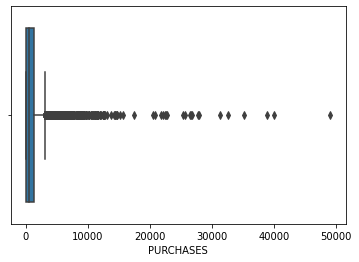

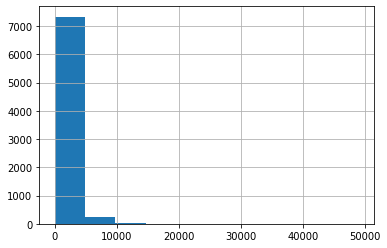

In [9]:
print(dataset["PURCHASES"].describe())
print("variation coefficient :",dataset["PURCHASES"].describe()["std"]/dataset["PURCHASES"].describe()["mean"])
ax = sns.boxplot(x=dataset["PURCHASES"])
plt.show()
dataset["PURCHASES"].hist()
plt.show()

In [10]:
index_names = dataset[ dataset['PURCHASES'] > 20000].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
2     2495.148862           1.000000     773.17            773.17   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.4 Cash advance
Same conclusion applies for cash given in advance. The range of small cash values are the most frequent ones. The probability distribution of the analysed metrics up untill now are somehow identical 

count     7604.000000
mean      1049.515273
std       2161.183844
min          0.000000
25%          0.000000
50%         39.481018
75%       1250.307142
max      47137.211760
Name: CASH_ADVANCE, dtype: float64
variation coefficient : 2.059220956390569


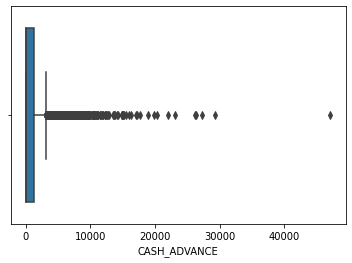

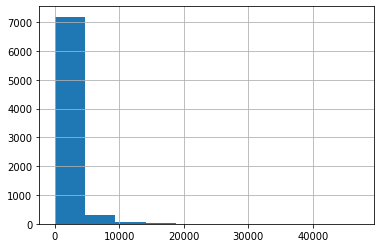

In [11]:
print(dataset["CASH_ADVANCE"].describe())
print("variation coefficient :",dataset["CASH_ADVANCE"].describe()["std"]/dataset["CASH_ADVANCE"].describe()["mean"])
ax = sns.boxplot(x=dataset["CASH_ADVANCE"])
plt.show()
dataset["CASH_ADVANCE"].hist()
plt.show()

In [12]:
index_names = dataset[ dataset['CASH_ADVANCE'] > 20000].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
2     2495.148862           1.000000     773.17            773.17   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.5 Purchases frequency
PURCHASES_FREQUENCY metric case is different from what we saw before. The frequencies spreads within a wide range of values. The purchase frequencies are equally distributed around 0.5, there are as much users who frequently make purchases as users who rarely make purchases. This variance is confimed by the large value of variation coefficient. 

count    7596.000000
mean        0.523835
std         0.405561
min         0.000000
25%         0.083333
50%         0.583333
75%         1.000000
max         1.000000
Name: PURCHASES_FREQUENCY, dtype: float64
variation coefficient : 0.7742163865381976


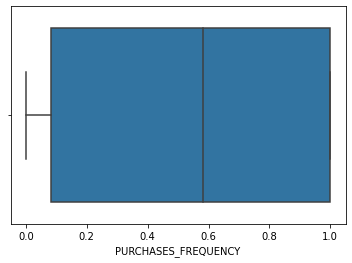

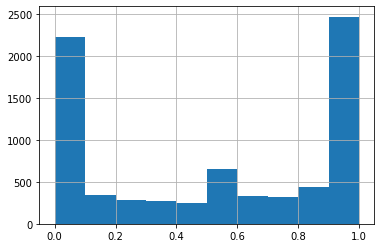

In [13]:
print(dataset["PURCHASES_FREQUENCY"].describe())
ax = sns.boxplot(x=dataset["PURCHASES_FREQUENCY"])
print("variation coefficient :",dataset["PURCHASES_FREQUENCY"].describe()["std"]/dataset["PURCHASES_FREQUENCY"].describe()["mean"])
plt.show()
dataset["PURCHASES_FREQUENCY"].hist()
plt.show()

## 3.5 One off purchases frequency
We notice that a large group of users rarely make one-off purchases while the rest are almost equally distributed from 0.1 till 1.0 with a slight decrease of proportion as we go further in terms frequencies.

count    7596.000000
mean        0.220646
std         0.309557
min         0.000000
25%         0.000000
50%         0.083333
75%         0.333333
max         1.000000
Name: ONEOFF_PURCHASES_FREQUENCY, dtype: float64
variation coefficient : 1.402955710509279


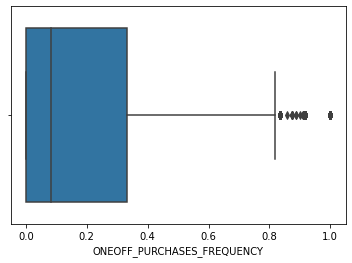

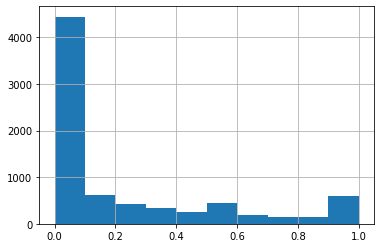

In [14]:
print(dataset["ONEOFF_PURCHASES_FREQUENCY"].describe())
ax = sns.boxplot(x=dataset["ONEOFF_PURCHASES_FREQUENCY"])
print("variation coefficient :",dataset["ONEOFF_PURCHASES_FREQUENCY"].describe()["std"]/dataset["ONEOFF_PURCHASES_FREQUENCY"].describe()["mean"])
plt.show()
dataset["ONEOFF_PURCHASES_FREQUENCY"].hist()
plt.show()

In [15]:
index_names = dataset[ dataset['ONEOFF_PURCHASES_FREQUENCY'] > 0.8].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.6 Purchases installments frequency

count    6861.000000
mean        0.379397
std         0.403641
min         0.000000
25%         0.000000
50%         0.250000
75%         0.833333
max         1.000000
Name: PURCHASES_INSTALLMENTS_FREQUENCY, dtype: float64


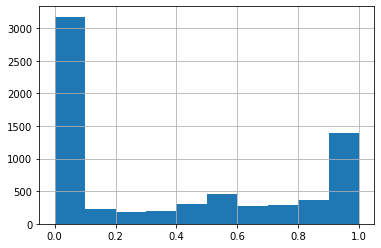

In [16]:
print(dataset["PURCHASES_INSTALLMENTS_FREQUENCY"].describe())
dataset["PURCHASES_INSTALLMENTS_FREQUENCY"].hist()
plt.show()

## 3.7 Cash advance frequency
As far as the remaining metrics are concerned, the probability distributions are almost identical. The main trend is that the smaller values of metrics are the most frequent ones. As the values of metrics gets larger, their proportion gets lower. It resemble the trend of an gaussian distribution for values greater than the mean.

count    6861.000000
mean        0.156501
std         0.209847
min         0.000000
25%         0.000000
50%         0.083333
75%         0.250000
max         1.500000
Name: CASH_ADVANCE_FREQUENCY, dtype: float64
variation coefficient : 1.3408647006922392


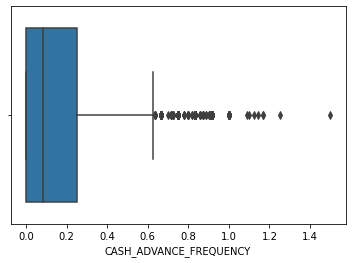

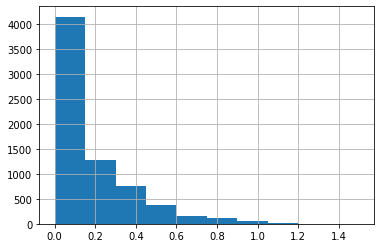

In [17]:
print(dataset["CASH_ADVANCE_FREQUENCY"].describe())
ax = sns.boxplot(x=dataset["CASH_ADVANCE_FREQUENCY"])
print("variation coefficient :",dataset["CASH_ADVANCE_FREQUENCY"].describe()["std"]/dataset["CASH_ADVANCE_FREQUENCY"].describe()["mean"])
plt.show()
dataset["CASH_ADVANCE_FREQUENCY"].hist()
plt.show()

In [18]:
index_names = dataset[ dataset['CASH_ADVANCE_FREQUENCY'] > 1.0].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.8 Cash advance trx


count    6853.000000
mean        3.733110
std         7.141274
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max       123.000000
Name: CASH_ADVANCE_TRX, dtype: float64
variation coefficient : 1.9129558168689849


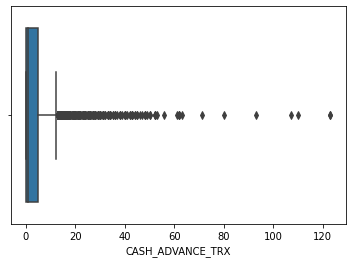

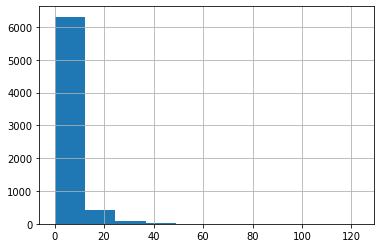

In [19]:
print(dataset["CASH_ADVANCE_TRX"].describe())
ax = sns.boxplot(x=dataset["CASH_ADVANCE_TRX"])
print("variation coefficient :",dataset["CASH_ADVANCE_TRX"].describe()["std"]/dataset["CASH_ADVANCE_TRX"].describe()["mean"])
plt.show()
dataset["CASH_ADVANCE_TRX"].hist()
plt.show()

In [20]:
index_names = dataset[ dataset['CASH_ADVANCE_TRX'] > 60].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.9 Purchases trx

count    6841.000000
mean       12.675340
std        20.263895
min         0.000000
25%         0.000000
50%         7.000000
75%        15.000000
max       347.000000
Name: PURCHASES_TRX, dtype: float64
variation coefficient : 1.5986864981797715


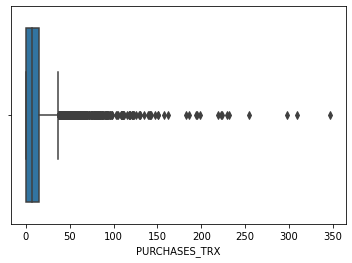

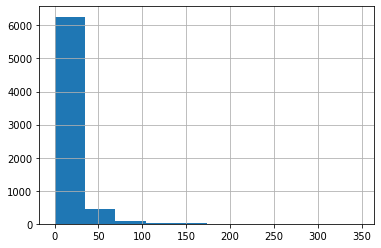

In [21]:
print(dataset["PURCHASES_TRX"].describe())
ax = sns.boxplot(x=dataset["PURCHASES_TRX"])
print("variation coefficient :",dataset["PURCHASES_TRX"].describe()["std"]/dataset["PURCHASES_TRX"].describe()["mean"])
plt.show()
dataset["PURCHASES_TRX"].hist()
plt.show()

In [22]:
index_names = dataset[ dataset['PURCHASES_TRX'] > 150].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.10 Credit limit

count     6823.000000
mean      4253.293080
std       3388.963439
min         50.000000
25%       1500.000000
50%       3000.000000
75%       6000.000000
max      30000.000000
Name: CREDIT_LIMIT, dtype: float64
variation coefficient : 0.7967857787010556


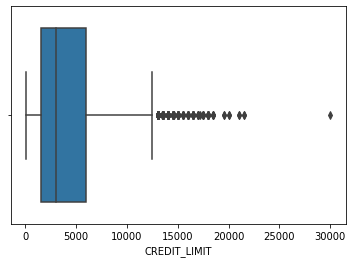

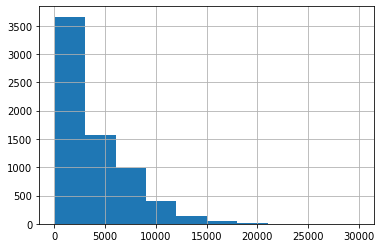

In [23]:
print(dataset["CREDIT_LIMIT"].describe())
ax = sns.boxplot(x=dataset["CREDIT_LIMIT"])
print("variation coefficient :",dataset["CREDIT_LIMIT"].describe()["std"]/dataset["CREDIT_LIMIT"].describe()["mean"])
plt.show()
dataset["CREDIT_LIMIT"].hist()
plt.show()

In [24]:
index_names = dataset[ dataset['CREDIT_LIMIT'] > 20000].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.11 Payments

count     6818.000000
mean      1525.620247
std       2084.192128
min          0.049513
25%        421.081654
50%        850.571175
75%       1756.450483
max      40627.595240
Name: PAYMENTS, dtype: float64
variation coefficient : 1.3661277318901333


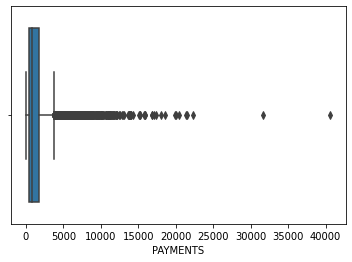

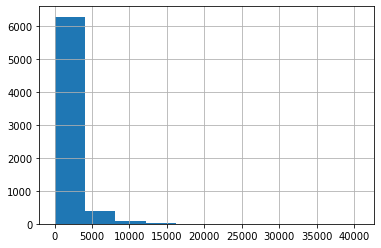

In [25]:
print(dataset["PAYMENTS"].describe())
ax = sns.boxplot(x=dataset["PAYMENTS"])
print("variation coefficient :",dataset["PAYMENTS"].describe()["std"]/dataset["PAYMENTS"].describe()["mean"])
plt.show()
dataset["PAYMENTS"].hist()
plt.show()

In [26]:
index_names = dataset[ dataset['PAYMENTS'] > 20000].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

## 3.12 Minimum Payments

count     6812.000000
mean       956.485470
std       2518.879978
min          2.167809
25%        181.391709
50%        392.160989
75%        929.817742
max      76406.207520
Name: MINIMUM_PAYMENTS, dtype: float64
variation coefficient : 2.633474378453365


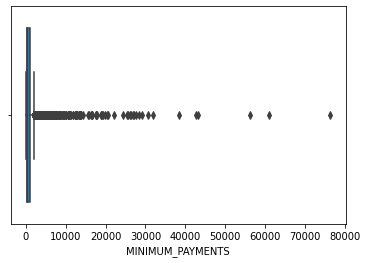

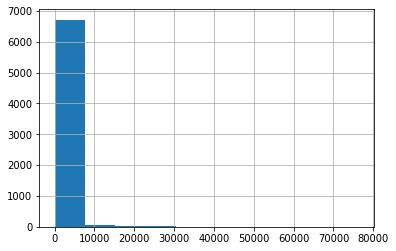

In [27]:
print(dataset["MINIMUM_PAYMENTS"].describe())
ax = sns.boxplot(x=dataset["MINIMUM_PAYMENTS"])
print("variation coefficient :",dataset["MINIMUM_PAYMENTS"].describe()["std"]/dataset["MINIMUM_PAYMENTS"].describe()["mean"])
plt.show()
dataset["MINIMUM_PAYMENTS"].hist()
plt.show()

In [28]:
index_names = dataset[ dataset['MINIMUM_PAYMENTS'] > 25000].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8942    40.829749           1.000000     113.28              0.00   
8945    28.493517           1.000000     291.12              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

count    6795.000000
mean        0.124464
std         0.258869
min         0.000000
25%         0.000000
50%         0.000000
75%         0.090909
max         1.000000
Name: PRC_FULL_PAYMENT, dtype: float64
variation coefficient : 2.0798720798581023


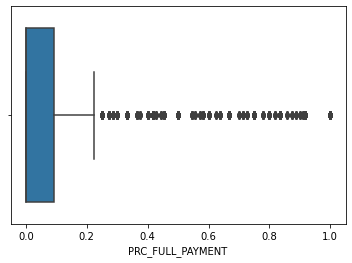

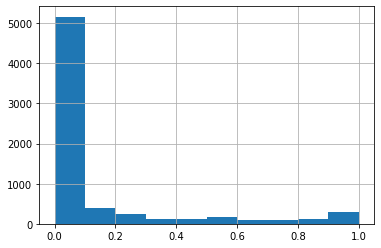

In [29]:
print(dataset["PRC_FULL_PAYMENT"].describe())
ax = sns.boxplot(x=dataset["PRC_FULL_PAYMENT"])
print("variation coefficient :",dataset["PRC_FULL_PAYMENT"].describe()["std"]/dataset["PRC_FULL_PAYMENT"].describe()["mean"])
plt.show()
dataset["PRC_FULL_PAYMENT"].hist()
plt.show()

In [30]:
index_names = dataset[ dataset['PRC_FULL_PAYMENT'] >= 0.5].index
dataset.drop(index_names, inplace = True)
print(dataset)

          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
4      817.714335           1.000000      16.00             16.00   
5     1809.828751           1.000000    1333.28              0.00   
7     1823.652743           1.000000     436.20              0.00   
...           ...                ...        ...               ...   
8941  5967.475270           0.833333     214.55              0.00   
8942    40.829749           1.000000     113.28              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.9

# 3 Bivariate analysis

<AxesSubplot:>

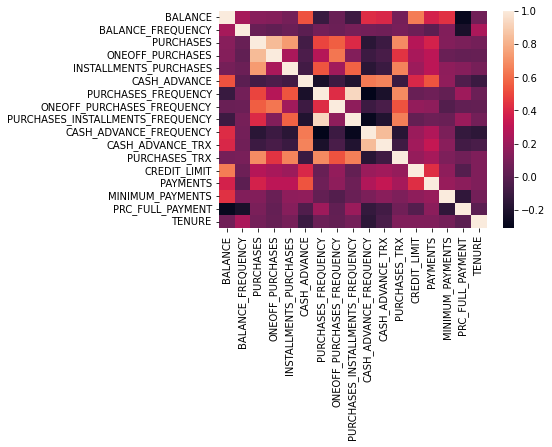

In [31]:
corr = dataset.corr()
sns.heatmap(corr)

We could confirm some of the previous colinearity hypothesises about the metrics PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES. We could literally replace ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, by ONEOFF_PURCHASES/PURCHASES, INSTALLMENTS_PURCHASES/PURCHASES or delete them both and keep ONEOFF_PURCHASES_FREQUENCY
and INSTALLMENTS_PURCHASES_FREQUENCY.
installment purchase frequency and purchases frequency are also closely corelated, we could eliminate one of them.

In [32]:
del dataset["ONEOFF_PURCHASES_FREQUENCY"]
del dataset["PURCHASES_FREQUENCY"]
del dataset["ONEOFF_PURCHASES"]
del dataset["INSTALLMENTS_PURCHASES"]

In [33]:
dataset["PURCHASES_TRX"] = dataset["PURCHASES_TRX"]/dataset["PURCHASES"]
for i in range(0,6042):
    if dataset["PURCHASES"].iloc[i] == 0:
        dataset["PURCHASES_TRX"].iloc[i] = 0
        

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [34]:
dataset["CASH_ADVANCE_TRX"] = dataset["CASH_ADVANCE_TRX"]/dataset["CASH_ADVANCE"]
for i in range(0,6042):
    if dataset["CASH_ADVANCE"].iloc[i] == 0:
        dataset["CASH_ADVANCE_TRX"].iloc[i] = 0

In [35]:
del dataset["CASH_ADVANCE"]

<AxesSubplot:>

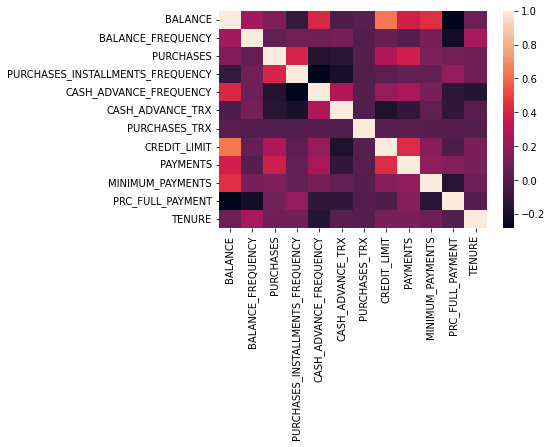

In [36]:
corr = dataset.corr()
sns.heatmap(corr)

In [37]:
dataset = dataset.dropna()

In [38]:
scaler = StandardScaler()
scaled = scaler.fit_transform(np.transpose([dataset["PURCHASES"]]))
dataset["PURCHASES"] = scaled
scaled = scaler.fit_transform(np.transpose([dataset["BALANCE"]]))
dataset["BALANCE"] = scaled
scaled = scaler.fit_transform(np.transpose([dataset["CREDIT_LIMIT"]]))
dataset["CREDIT_LIMIT"] = scaled
scaled = scaler.fit_transform(np.transpose([dataset["PAYMENTS"]]))
dataset["PAYMENTS"] = scaled
scaled = scaler.fit_transform(np.transpose([dataset["MINIMUM_PAYMENTS"]]))
dataset["MINIMUM_PAYMENTS"] = scaled
scaled = scaler.fit_transform(np.transpose([dataset["TENURE"]]))
dataset["TENURE"] = scaled
print(dataset.columns)
array_dataset = np.array(dataset)

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')


# 4 Principal components analysis

In [39]:
pca = PCA(n_components = 3)
Xscaled_principal = pca.fit_transform(array_dataset)
Xscaled_principal = pd.DataFrame(Xscaled_principal)
Xscaled_principal.columns = ["P1","P2","P3"]
print(pca.explained_variance_ratio_)

[0.35207066 0.24442303 0.10999146]


In [40]:
pca = PCA(n_components = 3)
Xscaled_normalized = normalize(array_dataset)
Xnormalized_principal = pca.fit_transform(Xscaled_normalized)
Xnormalized_principal = pd.DataFrame(Xnormalized_principal)
Xnormalized_principal.columns = ["P1","P2","P3"]
print(Xnormalized_principal.head())
print(pca.explained_variance_ratio_)

         P1        P2        P3
0 -0.712794 -0.037739 -0.001166
1  0.754580 -0.188138 -0.141503
2 -0.622590 -0.177855 -0.040333
3  0.005590  0.184059 -0.073411
4 -0.307392 -0.020695 -0.166873
[0.38209885 0.16876386 0.14628123]


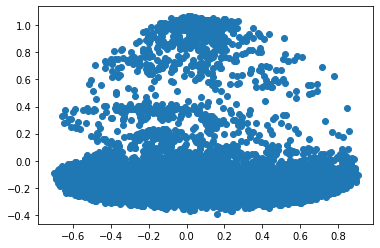

In [41]:
plt.scatter(Xnormalized_principal['P2'],Xnormalized_principal['P3'])
plt.show()

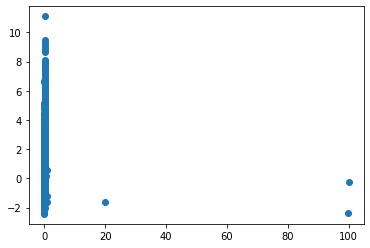

In [42]:
plt.scatter(Xscaled_principal['P1'],Xscaled_principal['P2'])
plt.show()

PCA didn't give good representative vectors low, since we already eliminated linearity in the previous part. 

# 5 Spectral Clustering

In [43]:
clustering = SpectralClustering(n_clusters=3,assign_labels='discretize',random_state=0)
colours = {}
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'


During, our first attempt to cluster we tried clustering people based only on their purchases and balance. We notice a large cluster (the blue one) that presents customers with low purchase rate and a balance distributed throughout all possible values, the largest portion of this cluster is the one that is too dense (bottom left side of the plot). it's precisely the group of people whose purchases rate and balance coordinates are close to each other. This specific group should be taken into account when conducting marketing activities such as advertising. In fact we should collect more data about this cluster.

silhouette score : 0.7668255198500907


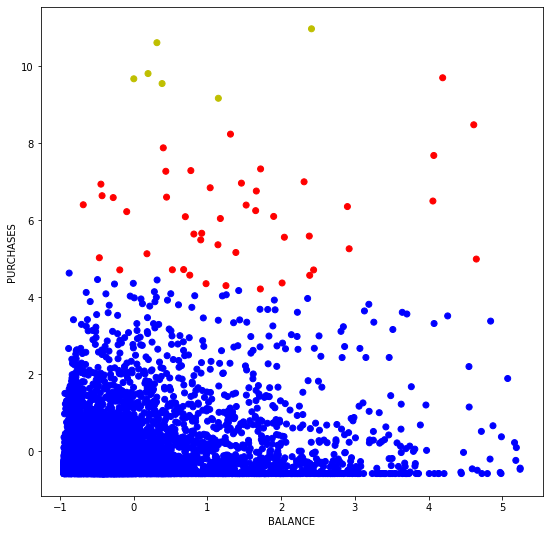

In [44]:
labels_rbf = clustering.fit_predict(dataset[['BALANCE','PURCHASES']]) 
cvec = [colours[label] for label in labels_rbf]
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['BALANCE','PURCHASES']], labels_rbf))

plt.scatter(dataset['BALANCE'], dataset['PURCHASES'], c = cvec)
plt.xlabel("BALANCE")
plt.ylabel("PURCHASES")
plt.show()

Next we notice once again a group of people whose purchase rate is low. This cluster presents customers whose one provide cash in advance with a frequency almost equally distributed from 0.1 to 1.These customers look for convenience, and minimum effort (set it and forget it).

silhouette score : 0.8429547574949069


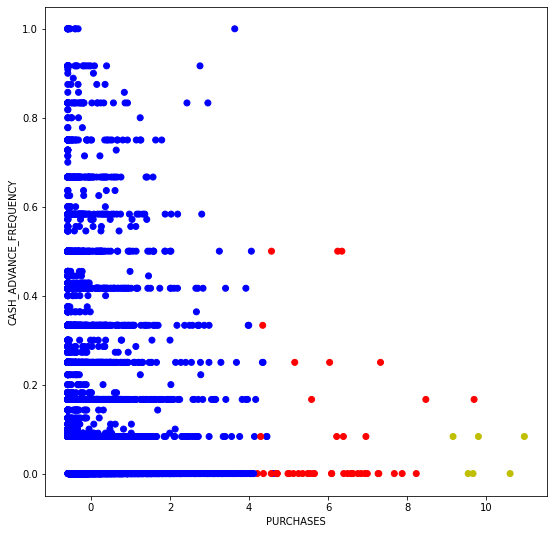

In [45]:
labels_rbf = clustering.fit_predict(dataset[['PURCHASES','CASH_ADVANCE_FREQUENCY']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['PURCHASES','CASH_ADVANCE_FREQUENCY']], labels_rbf))
plt.scatter(dataset['PURCHASES'], dataset['CASH_ADVANCE_FREQUENCY'], c = cvec)
plt.xlabel("PURCHASES")
plt.ylabel("CASH_ADVANCE_FREQUENCY")
plt.show()

Another noticeable segment of customers is the one who frequently pay money in advance prior to receiving the actual product. This segment is dense enough to be considered when making gifts to retain specifics portions of customers. These customers look for convenience, and minimum effort (set it and forget it). These customers probably have low balance, and update their balance amount frequently. 

silhouette score : 0.5693556566535106


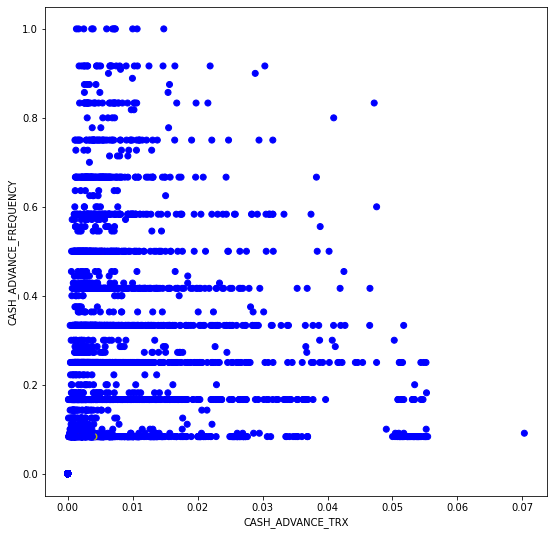

In [46]:
labels_rbf = clustering.fit_predict(dataset[['CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX']], labels_rbf))
plt.scatter(dataset['CASH_ADVANCE_TRX'], dataset['CASH_ADVANCE_FREQUENCY'], c = cvec)
plt.xlabel("CASH_ADVANCE_TRX")
plt.ylabel("CASH_ADVANCE_FREQUENCY")
plt.show()

Below we observe a cluster with the highest purchase installments rate. These people are somewhat the opposite of the previous clusters. They prefer to take time to fulfill purchases comfotably (probably because of the financial size of the product, real estates for example) by paying periodically for the product. These types purchases are likely to be investments.

silhouette score : 0.8277610000166502


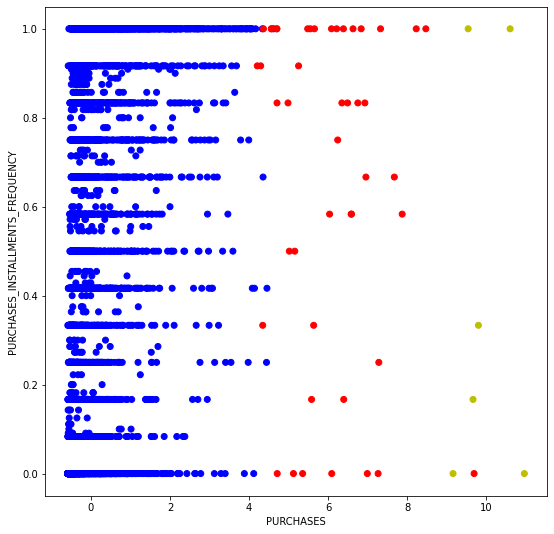

In [47]:
labels_rbf = clustering.fit_predict(dataset[['PURCHASES_INSTALLMENTS_FREQUENCY','PURCHASES']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['PURCHASES_INSTALLMENTS_FREQUENCY','PURCHASES']], labels_rbf))
plt.scatter(dataset['PURCHASES'], dataset['PURCHASES_INSTALLMENTS_FREQUENCY'], c = cvec)
plt.xlabel("PURCHASES")
plt.ylabel("PURCHASES_INSTALLMENTS_FREQUENCY")
plt.show()

There's also an interesting cluster characterized by descent amount of puchases combined with a good frequence of purchases (the red cluster), a segment that the business should consider to retain. 

silhouette score : 0.8545838470870873


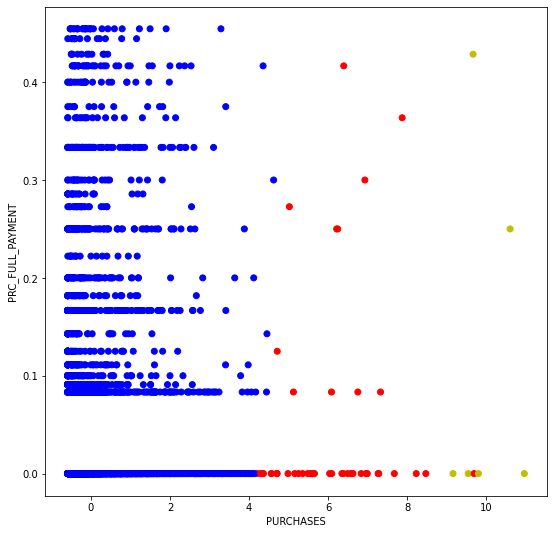

In [48]:
labels_rbf = clustering.fit_predict(dataset[['PRC_FULL_PAYMENT','PURCHASES']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['PRC_FULL_PAYMENT','PURCHASES']], labels_rbf))
plt.scatter(dataset['PURCHASES'], dataset['PRC_FULL_PAYMENT'], c = cvec)
plt.xlabel("PURCHASES")
plt.ylabel("PRC_FULL_PAYMENT")
plt.show()

Here the yellow cluster consist of customer with very little amount of balance (customer that usually pay their debt in due time, or who just conduct purchases in onego, no installments involved). 

silhouette score : 0.6678514377388642


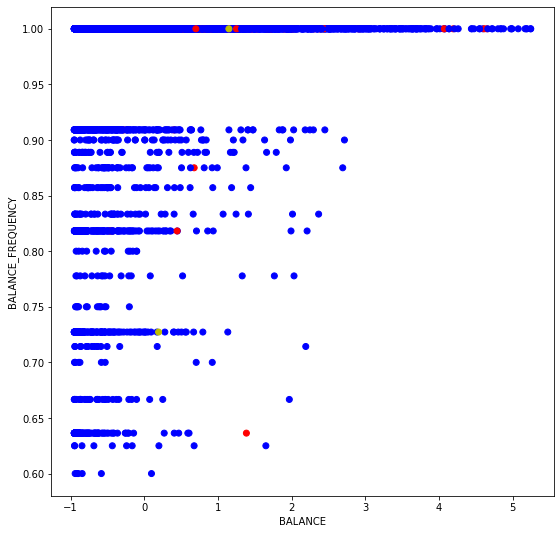

In [49]:
labels_rbf = clustering.fit_predict(dataset[['BALANCE','BALANCE_FREQUENCY']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['BALANCE','BALANCE_FREQUENCY']], labels_rbf))
plt.scatter(dataset['BALANCE'], dataset['BALANCE_FREQUENCY'], c = cvec)
plt.xlabel("BALANCE")
plt.ylabel("BALANCE_FREQUENCY")
plt.show()

Here we can notice two remarkable clusters, both the blue one and the red one. The blue one consists of customers whose minimum payments are relatively low and amount of payments are well distributed on a much wider range from 0 to 6. Therefore I think the blue cluster should be prioritized over the red one. The blue group of customers are likely to make more payments in the long term than the red group of people who only pay a lot occasionaly.

silhouette score : 0.8300583800622607


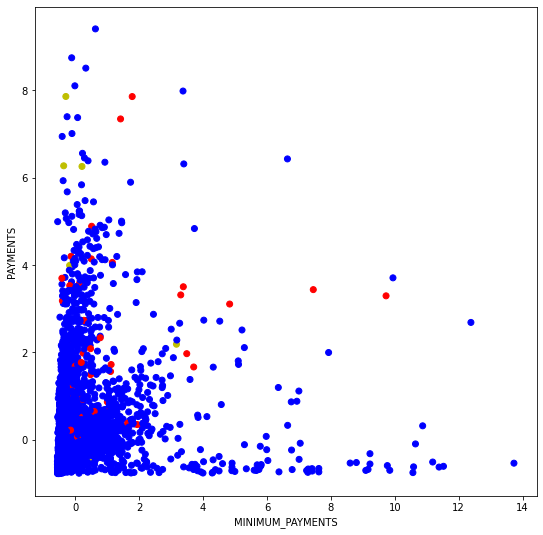

In [50]:
labels_rbf = clustering.fit_predict(dataset[['MINIMUM_PAYMENTS','PAYMENTS']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['MINIMUM_PAYMENTS','PAYMENTS']], labels_rbf))
plt.scatter(dataset['MINIMUM_PAYMENTS'], dataset['PAYMENTS'], c = cvec)
plt.xlabel("MINIMUM_PAYMENTS")
plt.ylabel("PAYMENTS")
plt.show()

Next, we will construct affinity matrix using a graph of nearest neighbors.
This graph suggests that every data point will be linked to his K nearest neighbors (following a certain distance measure that is euclidean measure). K is obviously a hyperparameter. The value of K used in the simulaltions is 10.

In [51]:
clustering = SpectralClustering(n_clusters=3,assign_labels='discretize',random_state=0,affinity="nearest_neighbors")


silhouette score : 0.20047077628448282


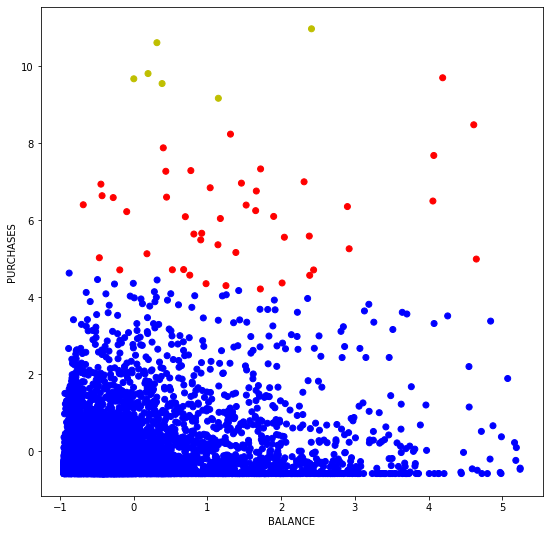

In [52]:
labels_rbf = clustering.fit_predict(dataset[['BALANCE','PURCHASES']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['BALANCE','PURCHASES']], labels_rbf))

plt.scatter(dataset['BALANCE'], dataset['PURCHASES'], c = cvec)
plt.xlabel("BALANCE")
plt.ylabel("PURCHASES")
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


silhouette score : -0.2799074868020506


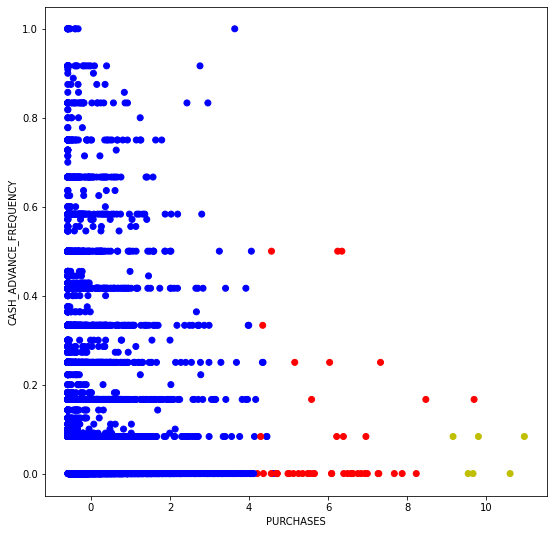

In [53]:
labels_rbf = clustering.fit_predict(dataset[['PURCHASES','CASH_ADVANCE_FREQUENCY']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['PURCHASES','CASH_ADVANCE_FREQUENCY']], labels_rbf))
plt.scatter(dataset['PURCHASES'], dataset['CASH_ADVANCE_FREQUENCY'], c = cvec)
plt.xlabel("PURCHASES")
plt.ylabel("CASH_ADVANCE_FREQUENCY")
plt.show()

silhouette score : 0.19778028421834218


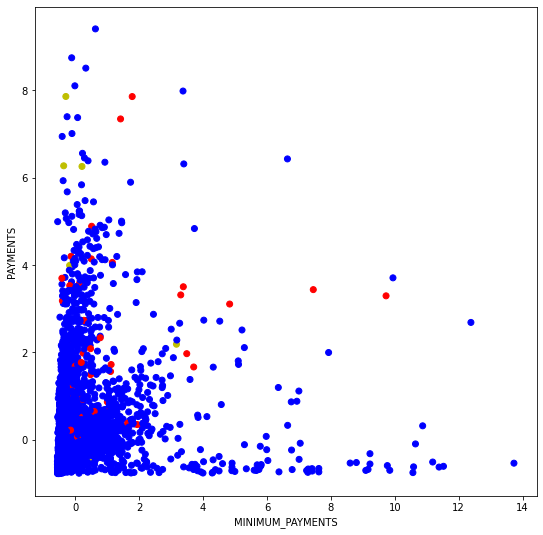

In [54]:
labels_rbf = clustering.fit_predict(dataset[['MINIMUM_PAYMENTS','PAYMENTS']]) 
plt.figure(figsize =(9, 9))
print("silhouette score :",silhouette_score(dataset[['MINIMUM_PAYMENTS','PAYMENTS']], labels_rbf))
plt.scatter(dataset['MINIMUM_PAYMENTS'], dataset['PAYMENTS'], c = cvec)
plt.xlabel("MINIMUM_PAYMENTS")
plt.ylabel("PAYMENTS")
plt.show()

Finally, we could notice poor results according to silhouette coefficient. In brief, the right way to construct affinity matrix was to apply radius basis function on the eucidian distance between every pair of data points.